# Visualization Playground for Detector Ideas

Use this notebook to quickly exercise the repo's existing plotting utilities, try small toy datasets, and sketch new visualization ideas for adversarial/OOD detection. The goal is to keep iterations lightweight and reproducible.

In [1]:
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

repo_root = pathlib.Path("..").resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.api import run_pipeline, list_datasets, list_models
from src.utils import ExperimentConfig
from src.data import TwoMoonsDatasetSpec, SyntheticShapes2ClassDatasetSpec
from src.visualization import (
    configure_mpl_style,
    plot_confusion_matrix,
    plot_roc_from_metrics,
    plot_score_distributions_figure,
    plot_persistence_diagram,
    plot_topology_summary_features,
    plot_local_neighborhood,
)

# Use publication-style defaults but keep LaTeX off for portability.
configure_mpl_style(latex=False)
plt.rcParams["figure.figsize"] = (6, 4)
np.set_printoptions(precision=3, suppress=True)

print("Datasets:", list_datasets())
print("Models:", list_models())

Datasets: ['breast_cancer_tabular', 'cifar10', 'cifar100', 'fashion_mnist', 'geometrical-shapes', 'mnist', 'synthetic_shapes_2class', 'synthetic_shapes_3class', 'two_moons']
Models: ['minicnn', 'two_moons_mlp']


In [ ]:
# --- Quick knobs to keep experiments small/fast ---
DATASET_NAME = "two_moons"       # "two_moons" or "synthetic_shapes_2class"
MODEL_NAME = "MLP"     # use "CNN" for synthetic_shapes_2class
N_SAMPLES = 600                   # total samples for dataset generator
SEED = 7
ATTACK_TYPE = "fgsm"             # "fgsm" or "pgd"
ATTACK_EPS = 0.12
MAX_POINTS_FOR_SCORING = 400      # subsample scoring to keep things snappy
RUN_OOD = False
OOD_METHOD = "feature_shuffle"
OOD_SEVERITY = 1.0

In [3]:
def load_dataset(dataset_name: str, *, n_samples: int, seed: int):
    """Return a DatasetBundle from src.data using tiny synthetic configs."""
    if dataset_name == "two_moons":
        cfg = type("Cfg", (object,), {
            "data": type("Data", (object,), {
                "n_samples": int(n_samples),
                "noise": 0.10,
                "train_ratio": 0.6,
                "val_ratio": 0.2,
                "test_ratio": 0.2,
                "random_state": int(seed),
            })(),
            "seed": int(seed),
        })()
        bundle = TwoMoonsDatasetSpec().load(cfg)
    elif dataset_name == "synthetic_shapes_2class":
        cfg = type("Cfg", (object,), {
            "data": type("Data", (object,), {
                "n_samples": int(n_samples),
                "train_ratio": 0.6,
                "val_ratio": 0.2,
                "test_ratio": 0.2,
                "random_state": int(seed),
            })(),
            "seed": int(seed),
        })()
        bundle = SyntheticShapes2ClassDatasetSpec(image_size=32).load(cfg)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    return bundle


bundle = load_dataset(DATASET_NAME, n_samples=N_SAMPLES, seed=SEED)
bundle.meta

{'input_kind': 'vector', 'clip': None, 'num_classes': 2}

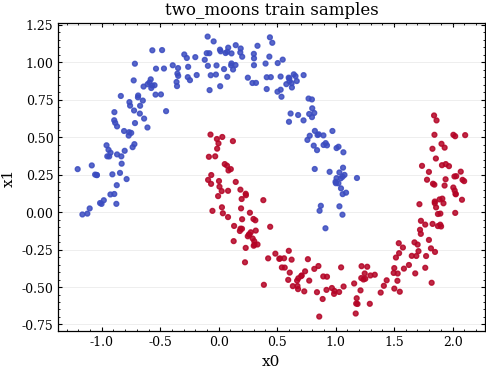

In [4]:
# Visual sanity check
import math

kind = bundle.meta.get("input_kind")
if kind == "vector":
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    ax.scatter(bundle.X_train[:, 0], bundle.X_train[:, 1], c=bundle.y_train, cmap="coolwarm", s=12, alpha=0.85)
    ax.set_title(f"{DATASET_NAME} train samples")
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
elif kind == "image":
    k = min(16, len(bundle.X_train))
    cols = 4
    rows = math.ceil(k / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.6, rows * 2.6))
    axes = np.asarray(axes).reshape(rows, cols)
    for i, ax in enumerate(axes.flat):
        ax.axis("off")
        if i < k:
            img = np.transpose(bundle.X_train[i], (1, 2, 0))
            ax.imshow(np.clip(img, 0, 1))
            ax.set_title(f"y={bundle.y_train[i]}")
    plt.tight_layout()
else:
    print(f"Unhandled input_kind={kind}")

Epoch [10/100] Train Loss: 0.2112, Train Acc: 89.44%, Val Loss: 0.1669, Val Acc: 92.50%
Epoch [20/100] Train Loss: 0.0896, Train Acc: 97.50%, Val Loss: 0.0635, Val Acc: 99.17%
Epoch [30/100] Train Loss: 0.0350, Train Acc: 99.17%, Val Loss: 0.0313, Val Acc: 99.17%
Epoch [40/100] Train Loss: 0.0187, Train Acc: 100.00%, Val Loss: 0.0212, Val Acc: 100.00%
Epoch [50/100] Train Loss: 0.0121, Train Acc: 100.00%, Val Loss: 0.0176, Val Acc: 100.00%
Epoch [60/100] Train Loss: 0.0086, Train Acc: 100.00%, Val Loss: 0.0148, Val Acc: 100.00%
Epoch [70/100] Train Loss: 0.0068, Train Acc: 100.00%, Val Loss: 0.0140, Val Acc: 100.00%
Epoch [80/100] Train Loss: 0.0065, Train Acc: 100.00%, Val Loss: 0.0139, Val Acc: 99.17%
Epoch [90/100] Train Loss: 0.0044, Train Acc: 100.00%, Val Loss: 0.0121, Val Acc: 99.17%
Early stopping at epoch 91
ROC AUC: 0.646
FPR@95TPR: 0.9167
Threshold: 0.5625


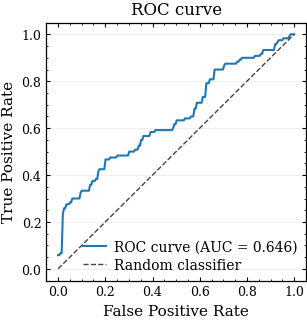

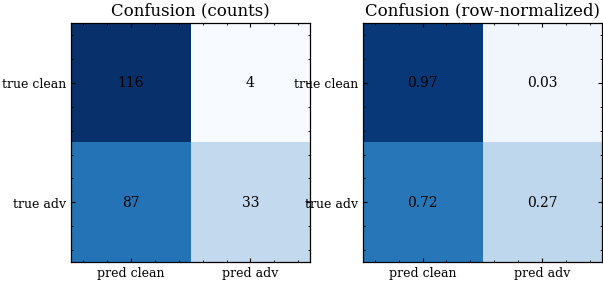

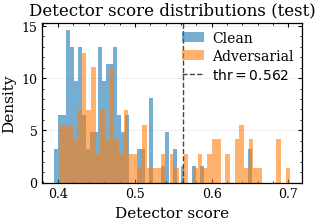

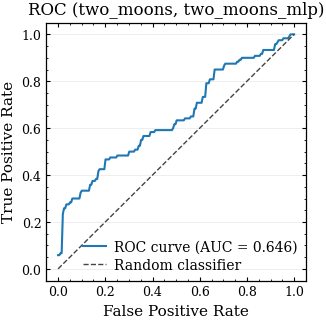

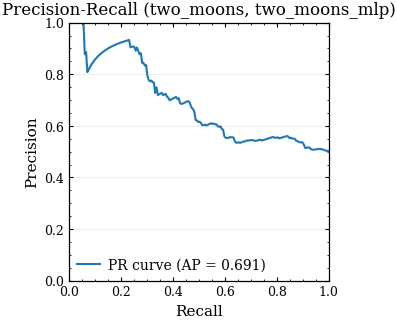

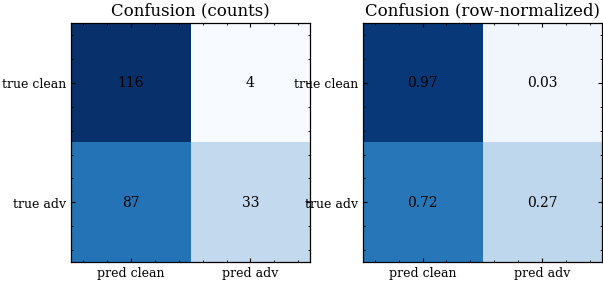

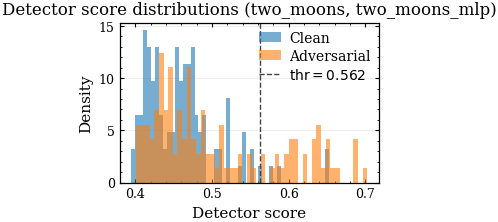

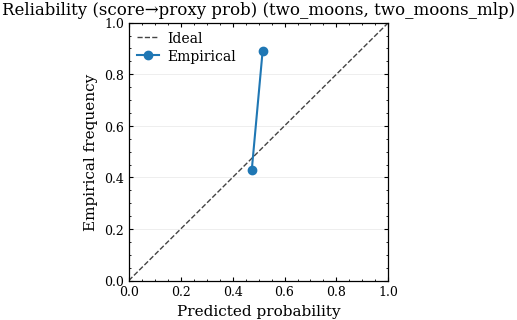

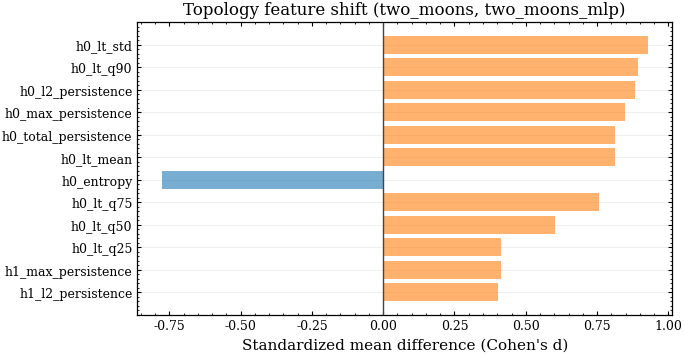

Saved report to: C:\Users\shockers\Desktop\topology-and-robustness-in-DNNs\example_notebook\results\paper_smoketest
Figures: {'roc': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_roc.png', 'pr': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_pr.png', 'confusion': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_confusion.png', 'score_distribution': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_score_distribution.png', 'reliability': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_reliability.png', 'topology_shift': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_topology_shift.png'}
Tables: {'

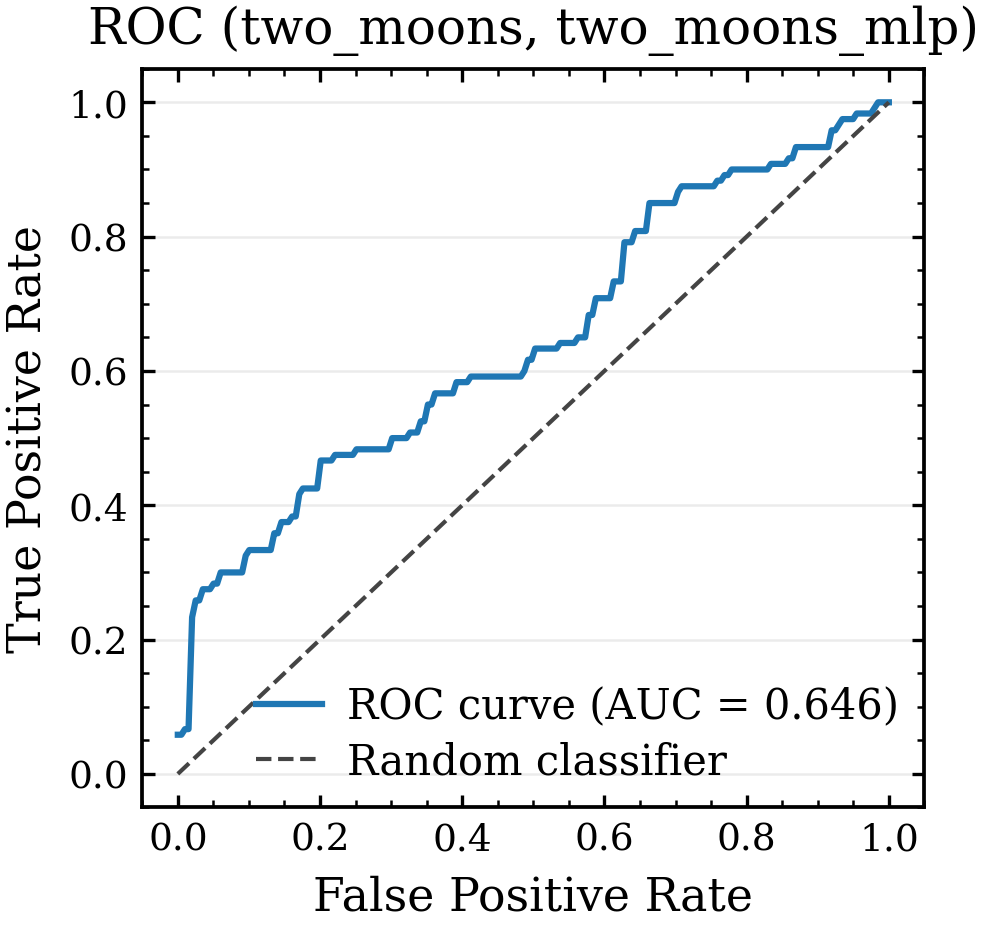

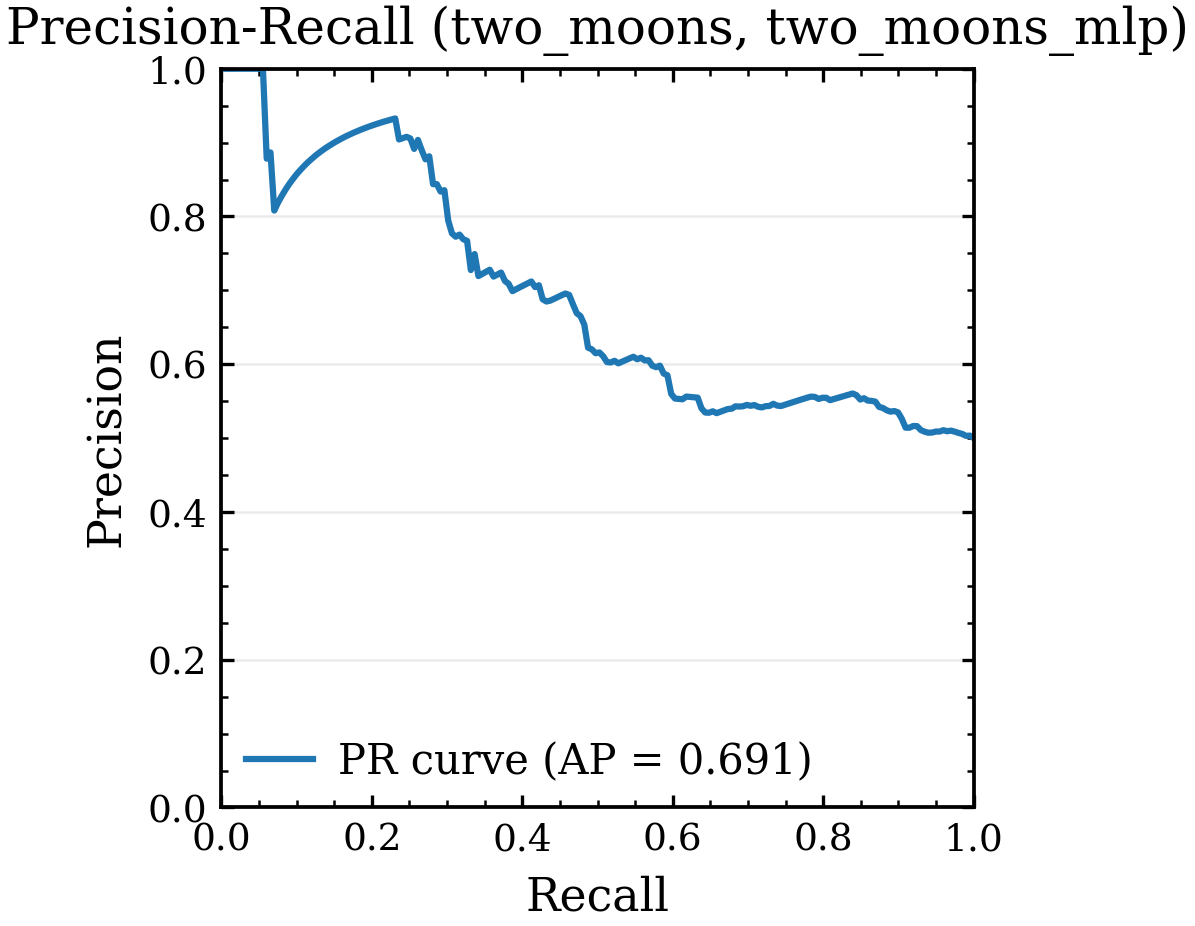

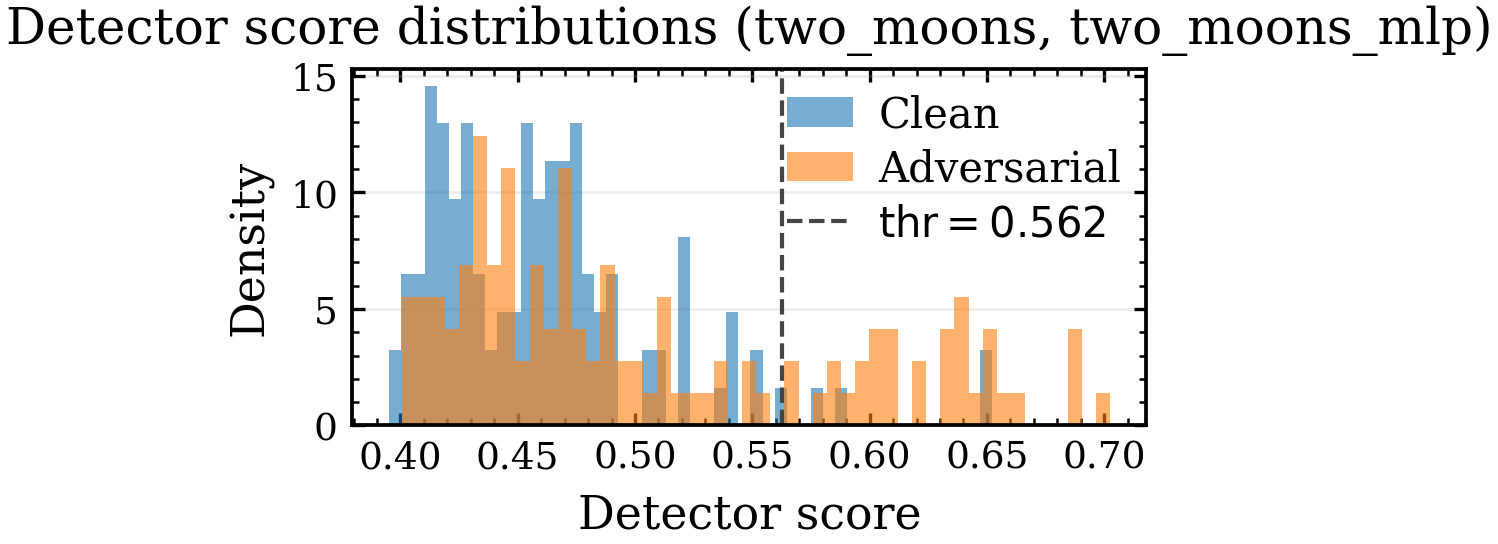

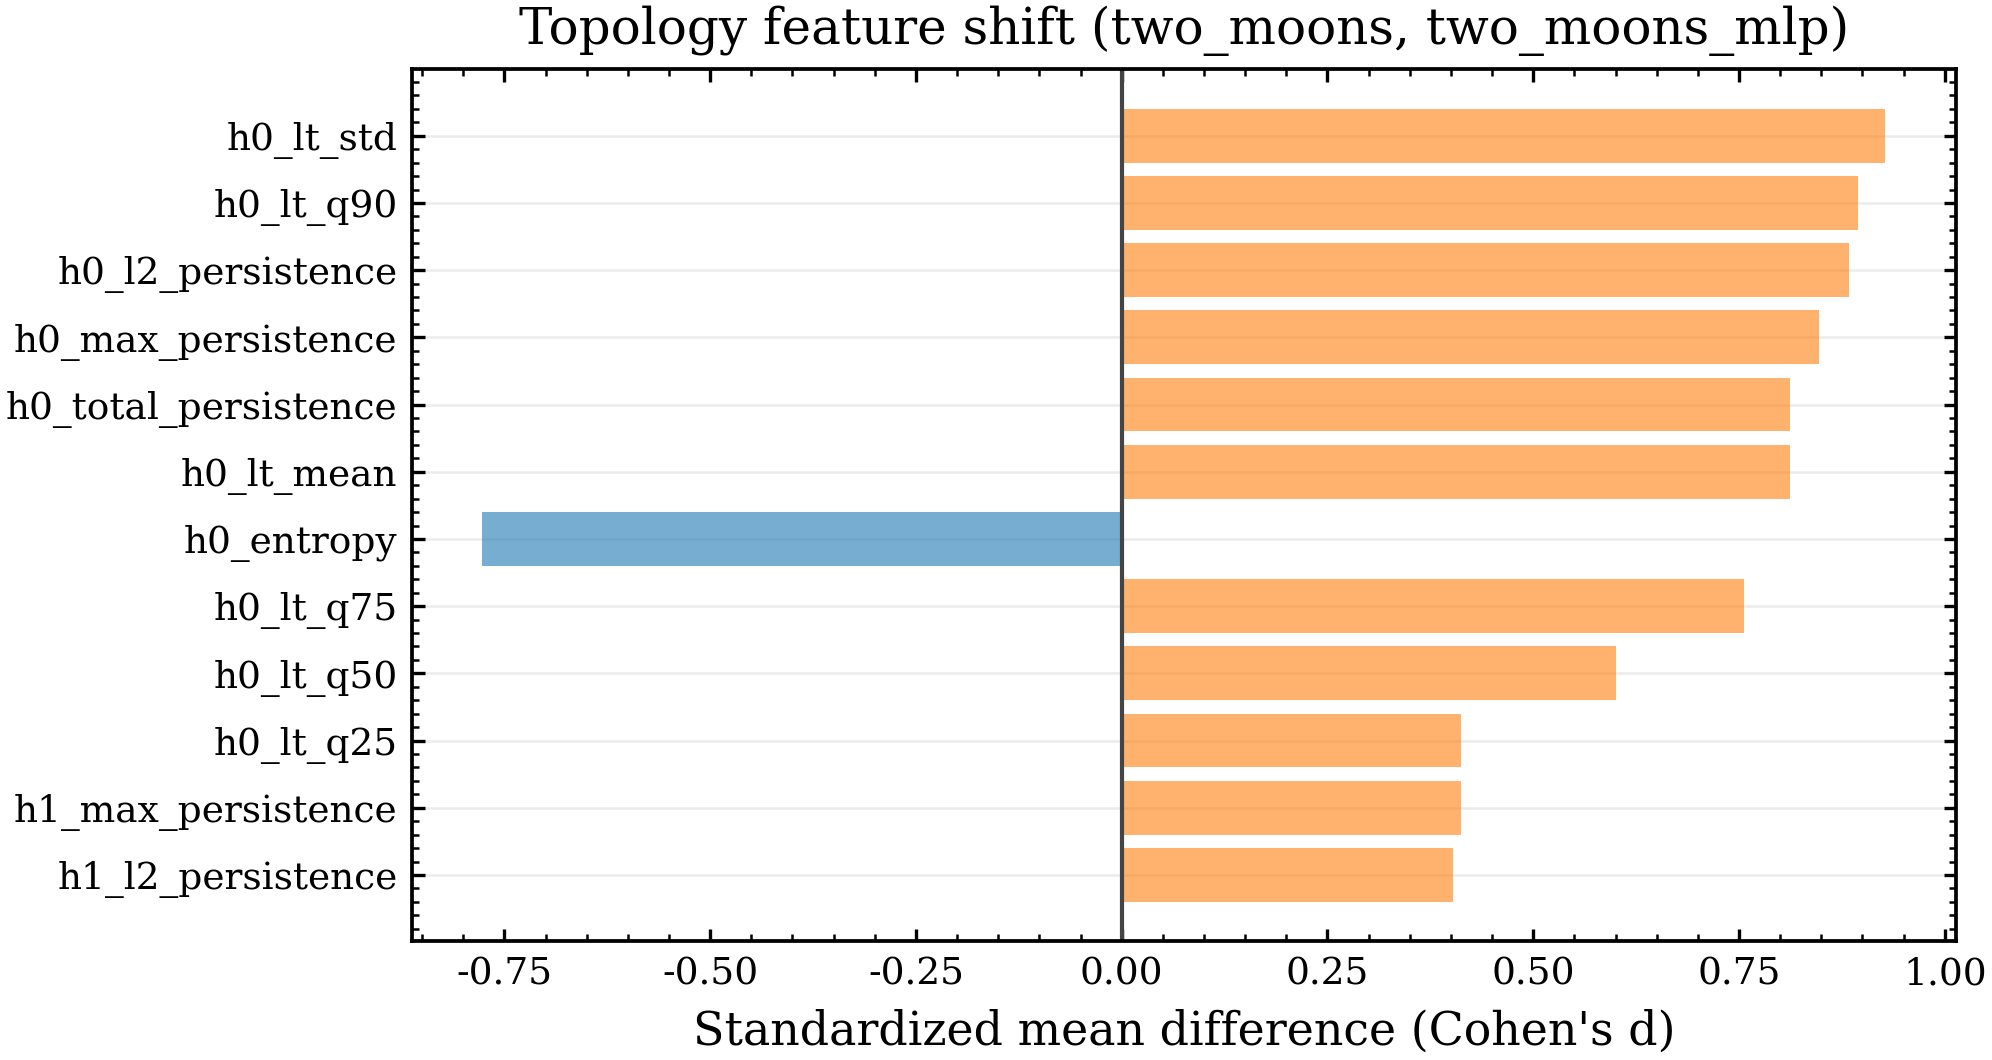

ReportArtifacts(figures={'roc': <Figure size 335x335 with 1 Axes>, 'pr': <Figure size 335x335 with 1 Axes>, 'confusion': <Figure size 690x310.5 with 2 Axes>, 'score_distribution': <Figure size 335x207.7 with 1 Axes>, 'reliability': <Figure size 335x335 with 1 Axes>, 'topology_shift': <Figure size 690x379.5 with 1 Axes>}, figure_paths={'roc': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_roc.png', 'pr': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_pr.png', 'confusion': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_confusion.png', 'score_distribution': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\results\\paper_smoketest\\smoke_score_distribution.png', 'reliability': 'C:\\Users\\shockers\\Desktop\\topology-and-robustness-in-DNNs\\example_notebook\\re

In [5]:
# End-to-end run + paper artifact export (PNG figures + CSV tables)
from pathlib import Path
from IPython.display import Image

from src.reporting import build_detector_report

cfg = ExperimentConfig(seed=SEED)
cfg.attack.attack_type = ATTACK_TYPE
cfg.attack.epsilon = ATTACK_EPS
cfg.device = "cpu"

# Enable topology features (required for topology_shift plots/tables)
# Keep k small for speed in notebooks
cfg.graph.use_topology = True
cfg.graph.topo_k = 40
cfg.graph.topo_maxdim = 1
cfg.graph.topo_preprocess = "pca"
cfg.graph.topo_pca_dim = 6

# Richer topology vectorization (more signal than the basic summaries)
cfg.graph.topo_feature_set = "rich"

# Enable class conditional 
cfg.detector.topo_class_conditional = False
cfg.detector.topo_class_covariance = "shared"
cfg.detector.topo_min_clean_per_class = 5

# Use all topo_* keys (recommended with topo_feature_set="rich")
cfg.detector.topo_feature_key_mode = "all"

cfg.detector.topo_clean_model = "iforest"
cfg.detector.topo_percentile = 95.0


# Small dataset overrides to keep runs quick
dataset_overrides = {
    "n_samples": int(N_SAMPLES),
    "train_ratio": 0.6,
    "val_ratio": 0.2,
    "test_ratio": 0.2,
}
if DATASET_NAME == "two_moons":
    dataset_overrides["noise"] = 0.10

max_points = int(MAX_POINTS_FOR_SCORING) if MAX_POINTS_FOR_SCORING else None

res = run_pipeline(
    dataset_name=DATASET_NAME,
    model_name=MODEL_NAME,
    cfg=cfg,
    dataset_overrides=dataset_overrides,
    make_plots=True,
    max_points_for_scoring=max_points,
    run_ood=RUN_OOD,
    ood_method=OOD_METHOD if RUN_OOD else None,
    ood_severity=OOD_SEVERITY if RUN_OOD else None,
)

metrics = res.eval.metrics
print(f"ROC AUC: {metrics.get('roc_auc', np.nan):.3f}")
print(f"FPR@95TPR: {metrics.get('fpr_at_tpr95', np.nan):.4f}")
print(f"Threshold: {res.detector.threshold:.4f}")

# ---- Paper report (png + csv) ----
out_dir = Path("results") / "paper_smoketest"

# Probability-like proxy used consistently in src.detectors: sigmoid(score - threshold)
raw_scores = np.asarray(res.eval.raw_scores, dtype=float)
probs = 1.0 / (1.0 + np.exp(-(raw_scores - float(res.detector.threshold))))
y_pred = (raw_scores >= float(res.detector.threshold)).astype(int)

s_clean = np.asarray(res.detector.score(res.scores_test_clean), dtype=float)
s_adv = np.asarray(res.detector.score(res.scores_test_adv), dtype=float)

topo_clean = {k: np.asarray(v) for k, v in res.scores_test_clean.items() if str(k).startswith("topo_")}
topo_adv = {k: np.asarray(v) for k, v in res.scores_test_adv.items() if str(k).startswith("topo_")}
feature_keys = list(getattr(res.detector, "feature_keys", []))
if len(feature_keys) == 0:
    feature_keys = sorted(set(topo_clean.keys()) & set(topo_adv.keys()))

art = build_detector_report(
    dataset_name=DATASET_NAME,
    model_name=MODEL_NAME,
    metrics=metrics,
    labels=np.asarray(res.eval.labels, dtype=int),
    scores=raw_scores,
    probabilities=probs,
    y_pred=y_pred,
    score_clean=s_clean,
    score_adv=s_adv,
    topology_scores_clean=topo_clean,
    topology_scores_adv=topo_adv,
    feature_keys=feature_keys,
    threshold=float(res.detector.threshold),
    out_dir=out_dir,
    prefix="smoke",
    use_latex=False,
    save_png_only=True,
)

print("Saved report to:", out_dir.resolve())
print("Figures:", art.figure_paths)
print("Tables:", art.table_paths)

# Quick inline preview of a couple outputs (optional)
for key in ["roc", "pr", "score_distribution", "topology_shift"]:
    p = art.figure_paths.get(key)
    if p and str(p).lower().endswith(".png"):
        display(Image(filename=str(p)))

art

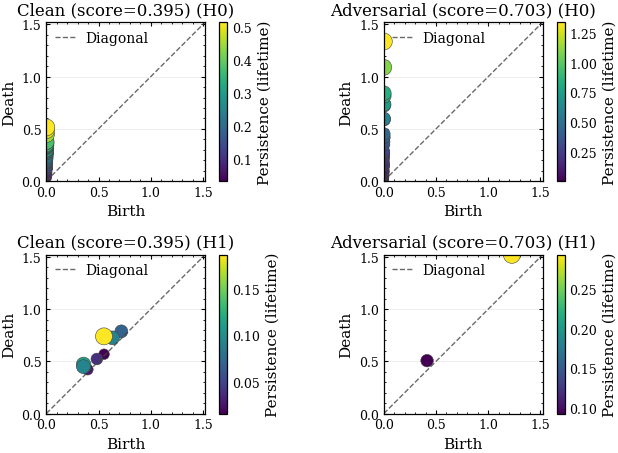

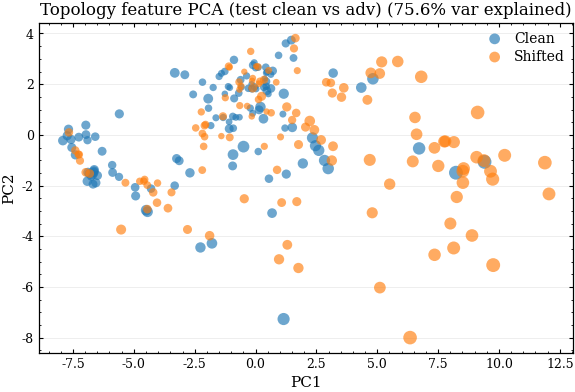

Clean idx: 118 score: 0.3949162514321478
Adv idx: 3 score: 0.7025233816839794
(If ripser is missing, install: pip install ripser)


In [6]:
# --- Qualitative PH comparisons (clean vs adversarial) ---
# Goal: compare persistence diagrams directly (H0/H1), on shared axes.

from src.models import extract_features_batch, get_model_logits
from src.graph_scoring import compute_graph_scores_with_diagrams
from src.visualization import plot_persistence_diagrams_grid, plot_topology_feature_pca

# Training representations used to build neighborhoods (same space as cfg.graph.space)
if cfg.graph.space == "feature":
    layer = str(getattr(cfg.graph, "feature_layer", "penultimate"))
    Z_train = extract_features_batch(res.model, res.bundle.X_train, layer=layer, device=str(cfg.device), batch_size=128)
else:
    Z_train = np.asarray(res.bundle.X_train)

# Model outputs for train (not required for PH, but kept for API consistency)
f_train = get_model_logits(res.model, res.bundle.X_train, device=str(cfg.device))

# Pick representative points on TEST split
s_clean = np.asarray(res.detector.score(res.scores_test_clean), dtype=float)
s_adv = np.asarray(res.detector.score(res.scores_test_adv), dtype=float)

idx_clean = int(np.argmin(s_clean))
idx_adv = int(np.argmax(s_adv))

x_clean = np.asarray(res.bundle.X_test)[idx_clean]
x_adv = np.asarray(res.attack_test.X_adv)[idx_adv]

# Compute PH diagrams for each point
feats_c, diags_c, cloud_c = compute_graph_scores_with_diagrams(
    X_point=x_clean,
    model=res.model,
    Z_train=Z_train,
    f_train=f_train,
    graph_params=cfg.graph,
    device=str(cfg.device),
)
feats_a, diags_a, cloud_a = compute_graph_scores_with_diagrams(
    X_point=x_adv,
    model=res.model,
    Z_train=Z_train,
    f_train=f_train,
    graph_params=cfg.graph,
    device=str(cfg.device),
)

# Plot diagrams side-by-side (H0..Hmaxdim)
plot_persistence_diagrams_grid(
    diags_c,
    diags_a,
    maxdim=int(getattr(cfg.graph, "topo_maxdim", 1)),
    min_persistence=float(getattr(cfg.graph, "topo_min_persistence", 1e-6)),
    title_clean=f"Clean (score={float(s_clean[idx_clean]):.3f})",
    title_shifted=f"Adversarial (score={float(s_adv[idx_adv]):.3f})",
)

# Optional: PCA view of topology feature vectors (the detector's v(x) space)
topo_clean = {k: np.asarray(v) for k, v in res.scores_test_clean.items() if str(k).startswith("topo_")}
topo_adv = {k: np.asarray(v) for k, v in res.scores_test_adv.items() if str(k).startswith("topo_")}
feature_keys = list(getattr(res.detector, "feature_keys", []))
if len(feature_keys) == 0:
    feature_keys = sorted(set(topo_clean.keys()) & set(topo_adv.keys()))

plot_topology_feature_pca(
    topo_clean,
    topo_adv,
    feature_keys=feature_keys,
    scores_clean=s_clean,
    scores_shifted=s_adv,
    title="Topology feature PCA (test clean vs adv)",
)

print("Clean idx:", idx_clean, "score:", float(s_clean[idx_clean]))
print("Adv idx:", idx_adv, "score:", float(s_adv[idx_adv]))
print("(If ripser is missing, install: pip install ripser)")


In [7]:
# Optional: verify the written files exist on disk
from pathlib import Path

out_dir = Path("results") / "paper_smoketest"
print("PNG files:")
for p in sorted(out_dir.glob("*.png")):
    print(" -", p)

print("CSV files:")
for p in sorted(out_dir.glob("*.csv")):
    print(" -", p)


PNG files:
 - results\paper_smoketest\smoke_confusion.png
 - results\paper_smoketest\smoke_pr.png
 - results\paper_smoketest\smoke_reliability.png
 - results\paper_smoketest\smoke_roc.png
 - results\paper_smoketest\smoke_score_distribution.png
 - results\paper_smoketest\smoke_topology_shift.png
CSV files:
 - results\paper_smoketest\smoke_metrics.csv
 - results\paper_smoketest\smoke_topology_shift.csv
